# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [27]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.decomposition import PCA

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
import scmemo, utils

In [161]:
data_path = '/data/parameter_estimation/interferon_data/20200316/'

### Perform some basic filtering

In [309]:
adata = sc.read(data_path + 'interferon_extended.raw.h5ad')
adata_all = sc.read(data_path + 'interferon.h5ad')
adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [163]:
adata.obs.cell.value_counts()

CD4 T cells          10373
CD14+ Monocytes      5355 
B cells              2571 
CD8 T cells          2040 
NK cells             1991 
FCGR3A+ Monocytes    1592 
Dendritic cells      432  
Megakaryocytes       208  
Name: cell, dtype: int64

In [164]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


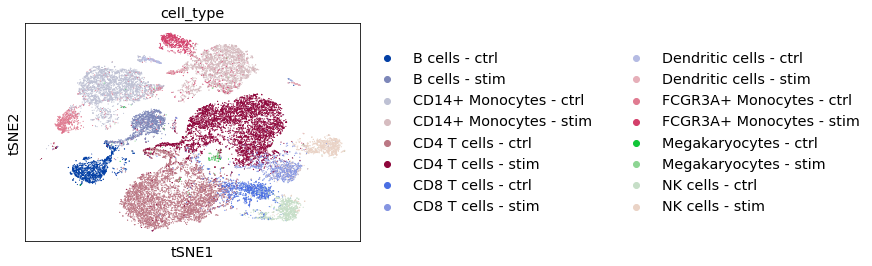

In [165]:
sc.pl.tsne(adata, color='cell_type')

In [166]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [167]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 5119


### Some useful functions

In [168]:
def density_scatterplot(a,b, s=1, cmap='Reds', kde=None):
    # Calculate the point density
    condition = np.isfinite(a) & np.isfinite(b)
    x = a[condition]
    y = b[condition]
    xy = np.vstack([x,y])
    z = stats.gaussian_kde(xy, bw_method=kde)(xy)
    print(z)
    plt.scatter(x, y, c=z, s=s, edgecolor='', cmap=cmap)
    

def robust_correlation(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    return stats.spearmanr(x,y)

def robust_linregress(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    print(x.min())
    
    return stats.linregress(x,y)

def robust_hist(x, **kwargs):
    
    condition = np.isfinite(x)
    plt.hist(x[condition], **kwargs)

### DB of TF and downstream genes

In [293]:
encode_data = pd.read_csv('gene_attribute_matrix.txt', sep='\t', index_col=0).iloc[2:, 2:].astype(float).astype(int)
encode_genes = df.index.values[np.where(encode_data['ARID3A'] > 0)[0]]
encode_data = encode_data.loc[list(set(encode_data.index) & set(adata.var.index)), list(set(encode_data.columns) & set(adata.var.index))]


In [294]:
df_list = []
for tf in encode_data.columns:
    
    downstream_genes = encode_data.index.values[np.where(encode_data[tf] > 0)[0]]
    df_list += [(tf, g) for g in downstream_genes]
df = pd.DataFrame(data=df_list, columns=['tf', 'gene'])


### TF DV vs Gene DV

In [186]:
with open(data_path + 'stim_effect_1d.pkl', 'rb') as f:
    stim_delta_dict = pkl.load(f)

In [ ]:
df_list = []
for tf in encode_data.columns:
    
    downstream_genes = encode_data.index.values[np.where(encode_data[tf] > 0)[0]]
    df_list += [(tf, g) for g in downstream_genes]
df = pd.DataFrame(data=df_list, columns=['tf', 'gene'])

ct = 'CD4 T cells'
df['tf_idx'] = [adata.var.index.tolist().index(g) for g in df['tf']]
df['gene_idx'] = [adata.var.index.tolist().index(g) for g in df['gene']]
df['tf_diff'] = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['de_diff'][df['tf_idx']]
df['gene_diff'] = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['de_diff'][df['gene_idx']]
df['tf_fdr'] = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['de_fdr'][df['tf_idx']]
df['gene_fdr'] = stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['de_fdr'][df['gene_idx']]
df = df.query('tf_fdr < 0.15 & gene_fdr < 0.15').query('tf != gene')

In [322]:
for ct in adata.obs.cell.drop_duplicates():
    for idx, gene in enumerate(adata.var.index):
        if 'STAT' in gene:
            print(ct, gene, stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['de_fdr'][idx], stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['de_diff'][idx])

CD14+ Monocytes STAT4 0.39950136897946104 0.30322515964508057
CD14+ Monocytes STAT6 0.10844560996243058 0.2054414302110672
CD14+ Monocytes STAT5B 0.4172730981470596 -0.28285348415374756
CD14+ Monocytes STAT5A 0.024849105722872862 0.6401656866073608
CD14+ Monocytes STAT3 3.422828646641398e-06 0.39681851863861084
CD4 T cells STAT4 0.5719308965233769 -0.07550894469022751
CD4 T cells STAT6 0.19986156083475712 -0.1877371370792389
CD4 T cells STAT5B 0.49646360956874575 -0.1384361982345581
CD4 T cells STAT5A 0.013286306511830102 0.4350990056991577
CD4 T cells STAT3 2.8352978302942896e-05 0.2928929924964905
Dendritic cells STAT4 0.9552023686367128 0.17517948150634766
Dendritic cells STAT6 0.7114333153906851 -0.196048304438591
Dendritic cells STAT5B 0.9649206882202298 -0.16132283210754395
Dendritic cells STAT5A 0.9825269619848039 -0.04423989728093147
Dendritic cells STAT3 0.24947543829872065 0.40441572666168213
NK cells STAT4 0.5109753987020622 -0.22090911865234375
NK cells STAT6 0.814297680206

In [321]:
for ct in adata.obs.cell.drop_duplicates():
    for idx, gene in enumerate(adata.var.index):
        if 'STAT' in gene:
            print(ct, gene, stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_fdr'][idx], stim_delta_dict[(ct + ' - ctrl', ct + ' - stim')]['dv_diff'][idx])

CD14+ Monocytes STAT4 0.24319630784481513 -0.2629303231157105
CD14+ Monocytes STAT6 0.5740685186296274 -0.13278980807136254
CD14+ Monocytes STAT5B 0.8544202276127637 0.08076018296961318
CD14+ Monocytes STAT5A 0.7040361988314293 -0.10131421294792597
CD14+ Monocytes STAT3 0.0003891771071139214 -1.3888630511973832
CD4 T cells STAT4 0.819722129047352 -0.0028606164873541395
CD4 T cells STAT6 0.5280226958971213 -0.038836738719167485
CD4 T cells STAT5B 0.2777900370638967 -0.07368695482588539
CD4 T cells STAT5A 0.9847886524775606 0.0071788756580479784
CD4 T cells STAT3 0.0011257741556048864 -0.25126438294846665
Dendritic cells STAT4 0.87132606905384 0.31732227132589563
Dendritic cells STAT6 0.9807986646700788 0.08953262809529106
Dendritic cells STAT5B 0.9932561080322018 -0.09004518359773828
Dendritic cells STAT5A 0.7210043056756593 0.33646098242656197
Dendritic cells STAT3 1.0 nan
NK cells STAT4 0.7184118086539838 -0.012887071651688231
NK cells STAT6 0.32614688804393627 0.09277208618052823
NK 

In [319]:
np.bincount(adata_all[:, 'STAT2'].X.astype(int))

array([26955,  1840,   221,    34,     9,     0,     2,     3,     1])

(array([2.8466e+04, 5.3300e+02, 5.9000e+01, 4.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ],
       dtype=float32),
 <a list of 10 Patch objects>)

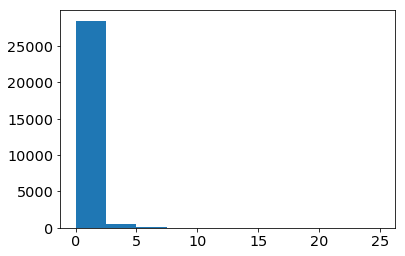

In [320]:
plt.hist(adata_all[:, 'STAT1'].X)

(array([2.6955e+04, 1.8400e+03, 2.2100e+02, 3.4000e+01, 0.0000e+00,
        9.0000e+00, 0.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ],
       dtype=float32),
 <a list of 10 Patch objects>)

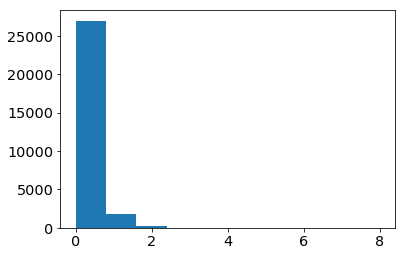

In [316]:
plt.hist(adata_all[:, 'STAT2'].X)

(array([2.4951e+04, 3.4710e+03, 5.2800e+02, 7.8000e+01, 2.0000e+01,
        8.0000e+00, 3.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ],
       dtype=float32),
 <a list of 10 Patch objects>)

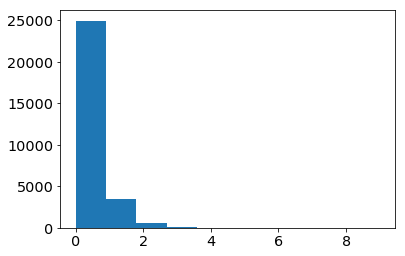

In [312]:
plt.hist(adata_all[:, 'STAT3'].X)

In [298]:
stats.linregress(df['tf_diff'], df['gene_diff'])

LinregressResult(slope=-0.006556708291851163, intercept=-0.16263642471224427, rvalue=-0.005525774383628279, pvalue=0.5460640015419775, stderr=0.010861126484678364)

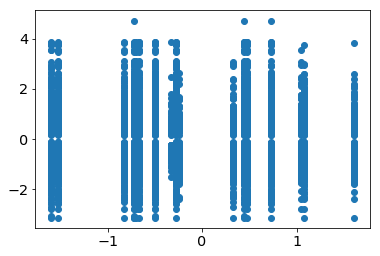

In [300]:
plt.scatter(df['tf_diff'], df['gene_diff'])


In [107]:
stim_delta_dict[('CD14+ Monocytes - ctrl',
  'CD14+ Monocytes - stim')]

{'log_mean_1': array([-2.29181314, -2.22282028, -1.96045613, ..., -0.83652651,
        -0.04052218, -1.34735203]),
 'log_mean_2': array([ 2.38567972, -2.98994637, -2.51037335, ..., -1.603652  ,
         0.68343234, -2.61045671]),
 'log_residual_var_1': array([0.61106935, 1.71040753, 2.07825478, ..., 0.20214204, 0.42729009,
        0.84702002]),
 'log_residual_var_2': array([ 0.63577923,  0.93361898,  1.14732602, ..., -0.01303159,
        -0.06414648,  0.58181201]),
 'de_diff': array([ 4.6774931 , -0.76712608, -0.54991722, ..., -0.76712549,
         0.7239545 , -1.26310468]),
 'de_pval': array([2.25238595e-06, 6.89931007e-02, 1.73582642e-01, ...,
        2.85199334e-04, 3.44208595e-08, 2.87012948e-05]),
 'de_fdr': array([2.13117914e-05, 9.78400273e-02, 2.21878765e-01, ...,
        6.44098016e-04, 3.07984738e-06, 8.28413716e-05]),
 'dv_diff': array([ 0.02470987, -0.77678855, -0.93092876, ..., -0.21517363,
        -0.49143658, -0.26520801]),
 'dv_pval': array([0.83011699, 0.43415658, 0.18

### Select immune genes using GO annotations

In [27]:
# go_annotations = pd.read_csv(data_path + '../GO_annotations-9606-inferred-allev.tsv', sep='\t')
# go_annotations['gene'] = go_annotations['gene_symbols'].apply(lambda x: x.split('|'))
# go_annotations = go_annotations\
#     .query('go_domain == "biological_process"')\
#     .explode('gene')[['go_name', 'gene']]

In [26]:
immune_genes = go_annotations[go_annotations.go_name.str.contains('immune')].gene.drop_duplicates().tolist()

NameError: name 'go_annotations' is not defined

In [21]:
genes_of_interest = list(set(adata.var.index) & set(immune_genes))

In [ ]:
with open(data_path + 'immune_genes.pkl', 'wb') as f:
    pkl.dump(genes_of_interest, f)

In [95]:
adata.var.shape

(5119, 5)

In [73]:
'IFNAR2' in adata.var.index

True

In [104]:
for gene in adata.var.index:
    if 'STAT' in gene:
        print(gene)

STAT4
STAT6
STAT3


In [34]:
adata[:, 'IFNAR1'].X.astype(int).mean()

0.06998107689661104

In [92]:
np.bincount(adata[adata.obs.stim=='ctrl', :][:, 'TYK2'].X.astype(int))

array([12063,   104,    92,     2])

In [100]:
	with open(data_path + 'immune_genes_to_test.pkl', 'rb') as f:
		immune_genes_to_test = pkl.load(f)

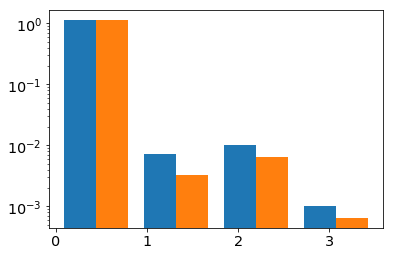

In [94]:
plt.hist(
    [adata[adata.obs.stim=='ctrl', :][:, 'TYK2'].X,adata[adata.obs.stim=='stim', :][:, 'TYK2'].X ],
    log=True, bins=4, density=True
    );

### Observed $\mu$-$CV^{2}$ Relationship

In [219]:
adata_sample = adata[adata.obs.cell == 'CD4 T cells']
#adata_sample = adata_sample[:, :100]

In [220]:
imp.reload(scmemo)
estimator = scmemo.SingleCellEstimator(
    adata=adata_sample, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

In [221]:
estimator.estimate_beta_sq(tolerance=3)

Computing observed moments for: CD4 T cells - ctrl
Computing observed moments for: CD4 T cells - stim


In [222]:
estimator.estimate_parameters()

In [223]:
%%time
estimator.compute_confidence_intervals_1d(
    groups=['CD4 T cells - ctrl', 'CD4 T cells - stim'], 
    groups_to_compare=[('CD4 T cells - ctrl', 'CD4 T cells - stim')],
    gene_tracker_count=100)

Computing the 0st/th gene
Computing the 100st/th gene
Computing the 200st/th gene
Computing the 300st/th gene


KeyboardInterrupt: 

In [208]:
%%time
estimator.compute_confidence_intervals_2d(
    gene_list_1=['HES4'],
    gene_list_2=['ID3'],
    groups=['CD4 T cells - ctrl', 'CD4 T cells - stim'], 
    groups_to_compare=[('CD4 T cells - ctrl', 'CD4 T cells - stim')])

CPU times: user 530 ms, sys: 140 µs, total: 530 ms
Wall time: 132 ms


In [203]:
estimator.parameters['CD4 T cells - stim'].keys()

dict_keys(['mean', 'log_mean', 'residual_var', 'log_residual_var', 'corr'])

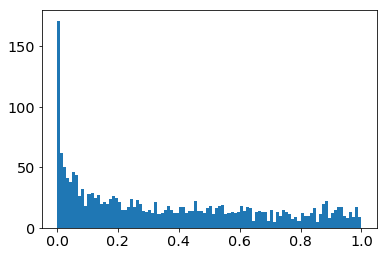

In [144]:
plt.hist(estimator.hypothesis_test_result_1d[('CD4 T cells - ctrl', 'CD4 T cells - stim')]['dv_pval'], bins=100);

In [161]:
a = np.random.randint(100, size=10000)

In [162]:
%%time
np.unique(a, return_counts=True)

CPU times: user 1.18 ms, sys: 0 ns, total: 1.18 ms
Wall time: 694 µs


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([105,  94,  78, 111, 109,  88, 102,  99, 102,  99,  90, 106,  95,
         80,  92, 115, 102, 111, 116, 111, 108,  80, 107, 103, 100,  78,
        102, 100,  91, 107,  99,  91,  91, 109,  92, 108,  98, 105, 109,
        109, 107, 105, 117, 108, 113, 111,  90,  88,  78, 105,  98, 104,
         95,  97, 105,  83,  88,  99,  89,  99, 101,  85, 104, 106, 103,
         96, 114, 111, 110,  91, 110, 102, 102,  97,  92,  93, 113,  97,
         89,  94, 101, 108,  98, 105, 112, 125, 101,  95,  99,  95,  96,
         87, 107, 110, 115,  95,  92,  

In [163]:
%%time
np.bincount(a)

CPU times: user 183 µs, sys: 0 ns, total: 183 µs
Wall time: 165 µs


array([105,  94,  78, 111, 109,  88, 102,  99, 102,  99,  90, 106,  95,
        80,  92, 115, 102, 111, 116, 111, 108,  80, 107, 103, 100,  78,
       102, 100,  91, 107,  99,  91,  91, 109,  92, 108,  98, 105, 109,
       109, 107, 105, 117, 108, 113, 111,  90,  88,  78, 105,  98, 104,
        95,  97, 105,  83,  88,  99,  89,  99, 101,  85, 104, 106, 103,
        96, 114, 111, 110,  91, 110, 102, 102,  97,  92,  93, 113,  97,
        89,  94, 101, 108,  98, 105, 112, 125, 101,  95,  99,  95,  96,
        87, 107, 110, 115,  95,  92,  87,  98,  93])